# Tweets sentiment analysis



##### Question: What is average sentiment of tweets connected with American Psychology Association ('#APA', '@APA' and subset of 'APA')  7-16 Jan?


##### Process:
- getting search results from Twitter API
- integrating multi phrase search csv files
- dataset preparation: language check, removing duplicates
- retriving and removing from text: RT symbol, hash, mention, url
- texts preparation: remove html, BOM, whitespaces, text to lowercase
- text preparation 2: lemmatizing, remove punct, remove stop words (and variant without lemma and stop words)
- evaluating sentiment of whole tweets (TextBlob)
- results, plots, value counts (general tendention direction is ok, however numbers look unaccurate)
- critical analysis of TextBlob words pick 
- improvement ideas



I need to mention, aside of reasonable analysis result in general sense, I highly doubt in TextBlob model, i think it needs to be heavily supported with curated list of stop words, DEP/POS points determining chunks and topic modelling - if not totaly replaced by use of pure deep learning models trained on curated datasets. Thus, this are plans for analysis in future.

In [77]:
from twython import Twython

import pandas as pd

from bs4 import BeautifulSoup
import re

import nltk  
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import textblob
from textblob import TextBlob 

import seaborn as sns
import matplotlib

In [49]:
# Getting tweets from twitter search (works with '@' and '#' prefix)
# ------------------------------------------------------------------

def connect_to_twitter(twitter_auth_path):
    with open(twitter_auth_path, 'r') as f:
        twitter_auth = json.load(f)
        APP_KEY = twitter_auth['APP_KEY'] # your app key
        APP_SECRET = twitter_auth['APP_SECRET'] # your app secret
        OAUTH_TOKEN = twitter_auth['OAUTH_TOKEN'] # your oauth token
        OAUTH_TOKEN_SECRET = twitter_auth['OAUTH_TOKEN_SECRET'] # your oauth token secret
    twitter = Twython(APP_KEY, APP_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
    return twitter

def get_tweet_data(tweet, tweet_data):        
    tweet_data['text'] = tweet['full_text']
    tweet_data['hashtags'] = get_hashtags_string(tweet)
    tweet_data['tweet_id'] = tweet['id']
    tweet_data['created_at'] = tweet['created_at']
    tweet_data['retweet_count'] = tweet['retweet_count']
    tweet_data['favorite_count'] = tweet['favorite_count']
    tweet_data['in_reply_to_status_id'] = tweet['in_reply_to_status_id']
    tweet_data['in_reply_to_screen_name'] = tweet['in_reply_to_screen_name']
    tweet_data['lang'] = tweet['lang']
    return tweet_data

def get_tweet_author_data(tweet, tweet_data):
    tweet_data['author'] = tweet['user']['screen_name']
    tweet_data['account_created_at'] = tweet['user']['created_at']
    tweet_data['author_description'] = tweet['user']['description']
    tweet_data['author_id'] = tweet['user']['id']
    tweet_data['author_location'] = tweet['user']['location']
    tweet_data['author_statuses_count'] = tweet['user']['statuses_count']
    tweet_data['author_followers_count'] = tweet['user']['followers_count']
    tweet_data['author_friends_count'] = tweet['user']['friends_count']
    tweet_data['author_favourites_count'] = tweet['user']['favourites_count']
    tweet_data['author_listed_count'] = tweet['user']['listed_count']
    return tweet_data

def get_hashtags_string(tweet):
    hashtags_string = ''
    for nr in range(len(tweet['entities']['hashtags'])):
        hashtags_string += tweet['entities']['hashtags'][nr]['text'] + ' '
    if not hashtags_string:
        hashtags_string = 'NO_HASHTAGS'
    return hashtags_string

def get_tweets_from_search(twitter, max_attempts, max_tweets_to_get, search_phrase):
    tweets_data = []
    for attempt_nr in range(0, max_attempts):
        if(max_tweets_to_get < len(tweets_data)):
            break

        if(0 == attempt_nr):
            search_results = twitter.search(q=search_phrase, count='100', tweet_mode='extended')
        else:
            search_results = twitter.search(q=search_phrase, include_entities='true', max_id=next_max_id, count='100', tweet_mode='extended')

        for tweet_data in search_results['statuses']:
            tweets_data.append(tweet_data)
        print('Loop: {} finished. Tweets gathered sum: {}.'.format(attempt_nr+1, len(tweets_data)))

        try:
            metadata = search_results['search_metadata']['next_results']
            next_max_id = metadata.split('max_id=')[1]
            next_max_id = next_max_id.split('&')[0]
        except:
            break
    return tweets_data

def return_as_df(all_tweets_list):
    tweet_df = pd.DataFrame(all_tweets_list)
    display(tweet_df.head(5), tweet_df.shape)
    return tweet_df

def save_tweets_as_CSV(save_path, tweet_df):
    tweet_nr = len(tweet_df)
    tweet_df.to_csv(save_path, sep='\t', encoding='utf-8', index=False)
    print('{} tweets saved to {}'.format(tweet_nr, save_path))

def get_tweets_by_search_phrase(s, max_tweets_to_get, max_attempts, twitter_auth_path):
    twitter = connect_to_twitter(twitter_auth_path)
    tweets_data = get_tweets_from_search(twitter, max_attempts, max_tweets_to_get, search_phrase)

    extracted_tweets_data = []
    for tweet in tweets_data:
        tweet_data = {}
        tweet_data = get_tweet_data(tweet, tweet_data)
        tweet_data = get_tweet_author_data(tweet, tweet_data)
        extracted_tweets_data.append(tweet_data)
    
    tweet_df = return_as_df(extracted_tweets_data)
    
    save_path = search_phrase + '_tweets.csv'
    save_tweets_as_CSV(save_path, tweet_df)
    
    return tweet_df

import json

In [50]:
# Example scrap results were gathered in previous session [dont want to exhaust download limits]

# Search Twitter for tweets with '@APA'
search_phrase = '@APA'
max_tweets_to_get = 100
max_attempts = 1
twitter_auth_path = 'twitter_auth.json'
at_df = get_tweets_by_search_phrase(search_phrase, max_tweets_to_get, max_attempts, twitter_auth_path)

Loop: 1 finished. Tweets gathered sum: 78.


,account_created_at,author,author_description,author_favourites_count,author_followers_count,author_friends_count,author_id,author_listed_count,author_location,author_statuses_count,created_at,favorite_count,hashtags,in_reply_to_screen_name,in_reply_to_status_id,lang,retweet_count,text,tweet_id
0,Wed Mar 21 04:44:39 +0000 2018,Ui_Neil,Future @RepPres Nominee. Apprentice of Pres Do...,1377,12,124,976318647949021184,0,"Of Indiana, In Florida",3979,Sat Jan 19 11:21:17 +0000 2019,0,NO_HASHTAGS,Ui_Neil,1.086579e+18,en,0,"@darpa @god is wanting sturgeon theory, surgeo...",1086584373313499137
1,Sun May 13 20:30:47 +0000 2012,carlbror,"Nationalekonom, programmerare och libertarian/...",1512,233,186,579264262,5,,2972,Sat Jan 19 11:16:01 +0000 2019,0,NO_HASHTAGS,None,NaN,en,333,RT @SteveStuWill: Pinker on the @APA Guideline...,1086583049737957376
2,Wed Nov 14 11:33:48 +0000 2018,apahabarcom,,0,13,119,1062669926236794880,0,,494,Sat Jan 19 11:15:32 +0000 2019,0,NO_HASHTAGS,None,NaN,in,0,Generasi Milenial Kini Menjadi Magnet Bagi Par...,1086582927226368001
3,Wed Aug 26 03:43:57 +0000 2015,Liberalism1984,,54278,242,393,3442977677,1,,4021,Sat Jan 19 11:14:44 +0000 2019,0,NO_HASHTAGS,None,NaN,en,118,RT @RealYeyoZa: Ideally in science you start e...,1086582725207822337
4,Tue Jun 17 17:28:51 +0000 2014,LazloCarreidas,Enjoying all the privileges of being male: I c...,1621,182,246,2573300323,7,,125,Sat Jan 19 11:07:59 +0000 2019,0,NO_HASHTAGS,DrLizBates,NaN,en,0,@DrLizBates \nOne hopes the @APA don’t hear of...,1086581027756216320


(78, 19)

78 tweets saved to @APA_tweets.csv


In [51]:
# Example scrap results were gathered in previous session [dont want to exhaust download limits]

# Search Twitter for tweets with '#APA'
search_phrase = '#APA'
max_tweets_to_get = 100
max_attempts = 1
twitter_auth_path = 'twitter_auth.json'
hash_df = get_tweets_by_search_phrase(search_phrase, max_tweets_to_get, max_attempts, twitter_auth_path)

Loop: 1 finished. Tweets gathered sum: 100.


,account_created_at,author,author_description,author_favourites_count,author_followers_count,author_friends_count,author_id,author_listed_count,author_location,author_statuses_count,created_at,favorite_count,hashtags,in_reply_to_screen_name,in_reply_to_status_id,lang,retweet_count,text,tweet_id
0,Sat Aug 13 06:50:58 +0000 2011,rururong,a (random & grumpy) typomania girl,1257,356,323,354156332,4,behind chu,83657,Sat Jan 19 10:47:59 +0000 2019,0,APA,None,NaN,tl,0,HUHUHU. #APA,1086575993056243712
1,Sun Jun 07 02:34:36 +0000 2009,PragatiSureka,"My forte is mental health,wellbeing &training ...",85,42,62,45267007,0,India,261,Sat Jan 19 10:31:52 +0000 2019,0,selflove HappyMakarSankranti anxiety apa selfp...,None,NaN,und,0,#selflove #HappyMakarSankranti #anxiety #apa #...,1086571940251398144
2,Sat Sep 02 18:59:02 +0000 2017,OptiMaleUK,OptiMale – check your testosterone and restore...,388,55,243,904056088978489345,0,United Kingdom,114,Sat Jan 19 10:18:25 +0000 2019,0,APA testosterone,None,NaN,en,0,When professional bodies are denying science t...,1086568555968110593
3,Mon Jun 04 04:16:12 +0000 2012,murninasionall,so fcking tired dude @targarlyen,98,240,470,598919987,0,hayolo,7492,Sat Jan 19 09:48:14 +0000 2019,0,apa,None,NaN,in,0,"Wreck It Ralph juga suka lagu Indonesia, judul...",1086560957378134017
4,Thu Jun 30 17:56:41 +0000 2011,NuriaCSopena,"#Periodista #feminista, autora de #HombresPorL...",53926,9147,1060,326912627,435,Madrid,68353,Sat Jan 19 09:18:28 +0000 2019,0,ViolenciaDeGénero,None,NaN,es,7,RT @jasjlion: Pues hoy he presentado un protoc...,1086553467823501313


(100, 19)

100 tweets saved to #APA_tweets.csv


In [52]:
# Example scrap results were gathered in previous session [dont want to exhaust download limits]

# Search Twitter for tweets with '#APA'
search_phrase = 'APA'
max_tweets_to_get = 300
max_attempts = 3
twitter_auth_path = 'twitter_auth.json'
phrase_df = get_tweets_by_search_phrase(search_phrase, max_tweets_to_get, max_attempts, twitter_auth_path)

Loop: 1 finished. Tweets gathered sum: 100.
Loop: 2 finished. Tweets gathered sum: 200.
Loop: 3 finished. Tweets gathered sum: 300.


,account_created_at,author,author_description,author_favourites_count,author_followers_count,author_friends_count,author_id,author_listed_count,author_location,author_statuses_count,created_at,favorite_count,hashtags,in_reply_to_screen_name,in_reply_to_status_id,lang,retweet_count,text,tweet_id
0,Sun Mar 04 13:15:50 +0000 2012,ShidQ_,sendiri kita kuat. bersama kita tak terkalahkan.,1406,13058,830,514328872,13,"Cirebon, Jawa Barat",41116,Sat Jan 19 11:24:35 +0000 2019,0,NO_HASHTAGS,pinkeurl,1.086585e+18,in,0,@pinkeurl Sakit apa?,1086585206121721856
1,Sat May 08 15:03:18 +0000 2010,YudhaGNA,Line & IG : ygn.21 | TheBlues #CFC @ChelseaFC ...,42,4340,439,141616290,0,"Bekasi, Indonesia",23679,Sat Jan 19 11:24:35 +0000 2019,0,NO_HASHTAGS,None,NaN,in,2332,RT @andihiyat: Apa aku harus berguru dulu sama...,1086585205098307584
2,Sat Aug 26 15:25:41 +0000 2017,essaybrooker,A little light on words. Heavy on coffee thoug...,1,11,36,901465681815842822,0,"Los Angeles, CA",4091,Sat Jan 19 11:24:35 +0000 2019,0,NO_HASHTAGS,None,NaN,en,0,[ANSWERED] Complete the following assignment u...,1086585204771352576
3,Mon Mar 28 12:49:53 +0000 2011,agung_espada,Cinta itu berawal dari kesederhanaan yang memb...,75,2255,2289,273408944,1,Pasuruan,14731,Sat Jan 19 11:24:35 +0000 2019,0,NO_HASHTAGS,None,NaN,in,0,Tidak semua yg kita ucapkan itu sama dgn apa y...,1086585204024602625
4,Sat Dec 29 02:06:03 +0000 2018,jjeontgook,"Roleplayer of @BTS_twt's maknae, Jeon Jungkook...",37,62,66,1078834501587918849,2,Golden Closet; KANPAI-11,1596,Sat Jan 19 11:24:34 +0000 2019,0,NO_HASHTAGS,jjeontgook,1.086585e+18,in,0,"Mereka saling menatap, nathan tak bisa menahan...",1086585202393047046


(300, 19)

300 tweets saved to APA_tweets.csv


In [44]:
# I. Load data from csv

#phrase_df = pd.read_csv('APA_tweets.csv', sep='\t', encoding='utf-8')
#hash_df = pd.read_csv('#APA_tweets.csv', sep='\t', encoding='utf-8')
#at_df = pd.read_csv('@APA_tweets.csv', sep='\t', encoding='utf-8')

# # a. Tag datasets
# phrase_df['tag'], hash_df['tag'], at_df['tag'] = 'phrase', 'hash', 'at'
# datasets = [at_df, phrase_df, hash_df]

# # b. Show raw
# print('Datasets:')
# for df in datasets:
#     display('DF {} shape: {}'.format(df.tag[0], df.shape))

In [65]:
# II. Dataset preparation

# 1. Join datasets for easier preprocessing
dfs = pd.concat(datasets)
dfs = pd.concat(df, datasets)
#dfs = dfs.loc[:,['text','retweet_count', 'lang', 'tag']]

# 2. Check tweet language
print('Check tweet language distribution:\n{}'.format(dfs.lang.value_counts().head(10)))

# 2b. Remove non english tweets
dfs = dfs[(dfs.lang == 'en')]

# 3. Check for duplicates
print('\n\nCheck for duplicates\n- Nr of entries {}\n- Uniq  entries {}'.format(dfs.shape[0], 
                                                                                dfs.text.unique().shape[0]))

# 3b. Remove duplicates
dfs = dfs.drop_duplicates(subset='text', keep='first')
dfs.reset_index(inplace=True, drop=True)

# 4. Check distribution of tweets over categories
print('\n\nDistribution of unique, english tweets over category tag [phrase, at, hash]:\n{}'.format(dfs.tag.value_counts()))

Check tweet language distribution:
in     4883
en     1914
ca      298
es      109
fr       84
und      49
tl       35
de       26
pt       17
ja       12
Name: lang, dtype: int64


Check for duplicates
- Nr of entries 1914
- Uniq  entries 610


Distribution of unique, english tweets over category tag [phrase, at, hash]:
hash      489
at         74
phrase     47
Name: tag, dtype: int64


In [45]:
# Check and save

#display('Combined_dataset of shape {}:'.format(dfs.shape), dfs.head(4))
# Save and work on CSV file
#df = dfs.copy(deep=True)
#save_tweets_as_CSV('apa_tweets_uniq.csv', df)
#df = pd.read_csv('apa_tweets_uniq.csv', sep='\t', encoding='utf-8') # .loc[:,['text','retweet_count
#df.head(1)

In [62]:
# Load all tweets CSV

df = pd.read_csv('apa_tweets_uniq.csv', sep='\t', encoding='utf-8') # .loc[:,['text','retweet_count


# I. Retrive informations from raw tweet texts:

# 1. Hashtags, mentions and text without
def get_mentions(text):
    return ', '.join([w for w in text.split(' ') if w.startswith('@')])
def get_hashtags(text):
    return ', '.join([w for w in text.split(' ') if w.startswith('#')])
def remove_hashtags_and_mentions(text):
    return ' '.join([w for w in text.split(' ') if not w.startswith('#') and not w.startswith('@')])
def get_and_remove_hashtags_and_mentions_from_text(text):
    return get_hashtags(text), get_mentions(text), remove_hashtags_and_mentions(text)

# 2. URL and text without
def get_url(text):
    try: 
        return re.search("(?P<url>https?://[^\s]+)", text).group("url")
    except: 
        return ''
def remove_url(text):
    return re.sub('https?://[A-Za-z0-9./]+','',text)
def get_and_remove_url_from_text(text):
    return get_url(text), remove_url(text)

# 3. RT sign and text without it
def get_and_remove_rt_from_text(text):
    if text[:2] == 'RT':
        return 1, text[3:]
    else:
        return 0, text

df['hashtags'], df['mentions'], df['text'] = zip(*df.text.apply(get_and_remove_hashtags_and_mentions_from_text))
df['link'], df['text'] = zip(*df.text.apply(get_and_remove_url_from_text))
df['RT'], df['text'] = zip(*df.text.apply(get_and_remove_rt_from_text))

# Also: a day feature
def get_date_day(date):
    return int(date.split(' ')[2])

df['day'] = df.created_at.apply(get_date_day)

# II. Clean rest of the text

def strip_html(text, praser='lxml'): # lxml', 'html.parser'
    return BeautifulSoup(text, praser).get_text()
def BOM_replace(text):
    try:
        return text.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        return text
def strip_inner_spaces(text):
    return ' '.join([w.strip() for w in text.split()])
def lowercase_text(text):
    return text.lower()

df['text'] = df.text.apply(strip_html)
df['text'] = df.text.apply(BOM_replace)
df['text'] = df.text.apply(strip_inner_spaces)
df['text'] = df.text.apply(lowercase_text)
# + case for can't - can not dict


# Prepare text for analysis: lemmatize, remove stop words & special characters

def lemmatize_words(text):
    WNL = WordNetLemmatizer()
    return ' '.join([WNL.lemmatize(word, pos='v') for word in text.split()])
# def stem_words_porter(text):
#     PS = PorterStemmer()
#     return ' '.join([PS.stem(w) for w in text.split()]) 
def remove_special_characters(text):
    return re.sub("[^a-zA-Z]", " ", text)
def remove_stop_words(text):
    return ' '.join([w for w in text.split() if not w in set(stopwords.words('english'))])

# Checking stop words to lemmas relation

df['text_stopworded'] = df.text.apply(remove_special_characters)
df['text_stopworded'] = df.text_stopworded.apply(strip_inner_spaces)
df['text_stopworded'] = df.text_stopworded.apply(remove_stop_words)

df['text_lemmatized'] = df.text.apply(lemmatize_words)
df['text_lemmatized'] = df.text_lemmatized.apply(remove_special_characters)
df['text_lemmatized'] = df.text_lemmatized.apply(strip_inner_spaces)

#df['text_lemmatized_stopworded'] = df.text.apply(stem_words_porter)
df['text_lemmatized_stopworded'] = df.text.apply(lemmatize_words)
df['text_lemmatized_stopworded'] = df.text_lemmatized_stopworded.apply(remove_special_characters)
df['text_lemmatized_stopworded'] = df.text_lemmatized_stopworded.apply(strip_inner_spaces)
df['text_lemmatized_stopworded'] = df.text_lemmatized_stopworded.apply(remove_stop_words)


df['text_stopworded_lemmatized'] = df.text.apply(remove_stop_words)
df['text_stopworded_lemmatized'] = df.text_stopworded_lemmatized.apply(lemmatize_words)
df['text_stopworded_lemmatized'] = df.text_stopworded_lemmatized.apply(remove_special_characters)
df['text_stopworded_lemmatized'] = df.text_stopworded_lemmatized.apply(strip_inner_spaces)

# Text pick
#df['test'] = df.text.apply(remove_stop_words)
df['text'] = df.text.apply(remove_special_characters)
df['text'] = df.text.apply(strip_inner_spaces)

# Inspect
print(df.shape)
#df.loc[1,['link','text']].tolist()
df.loc[:10,['link','RT', 'text']]

(849, 28)


,link,RT,text
0,,1,i was inspired by the and to finally write my ...
1,https://t.co/ThBcb7VIfD,0,came to cdspp for the accreditation meeting an...
2,,0,you d think these douchebag liberals never saw...
3,,0,i was inspired by the and to finally write my ...
4,,0,yes one team one fight
5,https://…,1,i have some thoughts on the new guidelines for...
6,,0,stossel is wrong in dismissing the importance ...
7,,0,i m disagreeing unfortunately although i appla...
8,,0,nope just leftist bullshit i m an academic and...
9,,1,moose toxic masculinity they probably learned ...


In [66]:
# Sentiment analisis basing on TextBlob

def get_sentiment_3_types(text): 
    sent_value = TextBlob(text)
    if sent_value.sentiment.polarity > 0: 
        return 'positive'
    elif sent_value.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'
    
def get_sentiment_val(text): 
    sent_value = TextBlob(text)
    return sent_value.sentiment.polarity

df['sentiment'] = df.text.apply(get_sentiment_val)
df.loc[:5,['text','sentiment']]

,text,sentiment
0,i was inspired by the and to finally write my ...,0.086111
1,came to cdspp for the accreditation meeting an...,0.000000
2,you d think these douchebag liberals never saw...,0.000000
3,i was inspired by the and to finally write my ...,0.086111
4,yes one team one fight,0.000000
5,i have some thoughts on the new guidelines for...,0.136364


In [67]:
# Critical analysis of TextBlob sote on words pick

def get_negative_positive_words_DUAL(text):
    positive, neutral, negative = [], [], []
    words = text.split()
    for w in words:
        w_blob = TextBlob(w)
        if w_blob.sentiment.polarity > 0:
            positive.append(w)
        elif w_blob.sentiment.polarity < 0:
            negative.append(w)
        else:
            neutral.append(w)
        
    return [' '.join(l) for l in (positive, neutral, negative)]

df['pos_words'], df['neu_words'], df['neg_words'] = zip(*df.text.apply(get_negative_positive_words_DUAL))

df.loc[:100,['text','pos_words','neu_words', 'neg_words','sentiment']].head(100)


# - i suppose model would work much better in combination with:
# --- point system on DEP, Tags
# --- separately concidered chunks on ROOTs, nouns and its words
# --- topic modelling
# --- carefur curation of stopwords list

,text,pos_words,neu_words,neg_words,sentiment
0,i was inspired by the and to finally write my ...,most,i was inspired by the and to finally write my ...,down,0.086111
1,came to cdspp for the accreditation meeting an...,,came to cdspp for the accreditation meeting an...,,0.000000
2,you d think these douchebag liberals never saw...,,you d think these douchebag liberals never saw...,,0.000000
3,i was inspired by the and to finally write my ...,most,i was inspired by the and to finally write my ...,down,0.086111
4,yes one team one fight,,yes one team one fight,,0.000000
5,i have some thoughts on the new guidelines for...,new,i have some thoughts on the guidelines for psy...,,0.136364
6,stossel is wrong in dismissing the importance ...,,stossel is in dismissing the importance of it ...,wrong,-0.250000
7,i m disagreeing unfortunately although i appla...,,i m disagreeing although i applaud your revere...,unfortunately military negative,-0.180000
8,nope just leftist bullshit i m an academic and...,,nope just bullshit i m an academic and deal wi...,leftist everyday,-0.083333
9,moose toxic masculinity they probably learned ...,masculine social cultural,moose toxic masculinity they probably learned ...,wide,0.033333


In [68]:
# Sentiment by a day
temp = df.loc[:,['text','pos_words','neg_words','sentiment', 'day']]
display(temp.head(4))
temp.day.value_counts()

,text,pos_words,neg_words,sentiment,day
0,i was inspired by the and to finally write my ...,most,down,0.086111,17
1,came to cdspp for the accreditation meeting an...,,,0.000000,17
2,you d think these douchebag liberals never saw...,,,0.000000,17
3,i was inspired by the and to finally write my ...,most,down,0.086111,17


16    374
9      77
12     61
11     59
10     59
14     47
15     46
13     38
17     32
8      29
7      24
6       3
Name: day, dtype: int64

In [69]:
# Hash type value couts
df.tag.value_counts()

hash      482
at        326
phrase     41
Name: tag, dtype: int64

In [71]:
# Top words (positive and negative)

def get_all_words_in_column(df_column):
    column_words = []
    for row_words in df_column:
        words = row_words.split()
        for w in words:
            column_words.append(w)
    return column_words

def get_unique_words_in_column(df_column):
    column_words = []
    for row_words in df_column:
        words = row_words.split()
        for w in words:
            column_words.append(w)
    return set(column_words)

def the_words_counts():
    # Counter
    # DF value_counts
    pass


def describe_words(df_column, words_name='Provided', max_words=10):
    all_words = get_all_words_in_column(df_column)
    unique_words = get_unique_words_in_column(df_column)
    word_counts = Counter(all_words).most_common(len(all_words))
    
    print("--------------")
    print("{} words".format(words_name))
    print("--------------")

    print("Nr of all {} words: {}".format(words_name.lower(), len(all_words)))
    print("Nr of unique {} words: {}".format(words_name.lower(), len(unique_words)))
    print('\nTop {} {} words:'.format(max_words, words_name.lower()))
    for w in word_counts[:max_words]:
        print("-", w[0], w[1])
    print()
    
    return all_words, unique_words, word_counts

neg_all_words, neg_unique_words, neg_word_counts = describe_words(df.neg_words, 'Negative', 50)
pos_all_words, pos_unique_words, pos_word_counts = describe_words(df.pos_words, 'Positive', 50)

--------------
Negative words
--------------
Nr of all negative words: 390
Nr of unique negative words: 133

Top 50 negative words:
- mental 34
- bad 21
- other 17
- behind 13
- shoddy 12
- down 11
- wrong 10
- long 8
- evil 8
- hard 7
- less 7
- worse 7
- mean 6
- half 6
- crap 6
- leftist 5
- small 5
- sorry 5
- common 5
- negative 4
- few 4
- shit 4
- tough 4
- little 4
- sick 4
- fucking 4
- widely 4
- unhealthy 4
- outraged 4
- stupid 4
- angry 3
- single 3
- typical 3
- dangerous 3
- ill 3
- crying 3
- extreme 3
- least 3
- active 2
- corrupt 2
- fake 2
- obstacles 2
- idiots 2
- expected 2
- seriously 2
- incoherent 2
- exaggerated 2
- disappointed 2
- false 2
- excuse 2

--------------
Positive words
--------------
Nr of all positive words: 840
Nr of unique positive words: 197

Top 50 positive words:
- new 84
- more 41
- most 26
- first 23
- good 20
- great 20
- very 18
- masculine 16
- many 16
- right 16
- free 16
- social 15
- love 15
- real 14
- better 14
- professional 13
-

[Text(0,0.5,'Mean sentiment'), Text(0.5,0,'Day')]

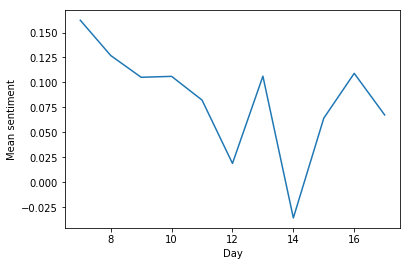

In [73]:
# Result:


def representative_samples(column, condition):
    return [category for category in column.unique() if column.value_counts()[category] > condition]

#def representative_samples(column, condition):
#    column_categories = column.unique()
#    category_samples_count = column.value_counts()[category]
#    return [category for category in column_categories if category_samples_count > condition]


def df_subset(df, condition_col, condition):
    return  df[condition_col == condition]

df = df_bckup.copy(deep=True)
daily_sentiment = []
for d in representative_samples(df.day, condition=20):
    subset = df_subset(df, df.day, d)
    day_sentiment = subset.sentiment.mean()
    daily_sentiment.append({'day': d, 'sentiment': day_sentiment})
    
result_plot = pd.DataFrame(daily_sentiment)
plot = sns.lineplot(x='day',y='sentiment', data=result_plot)
plot.set(xlabel = 'Day', ylabel = 'Mean sentiment')

['at'] [17] (31, 3)
['at'] [16] (295, 3)
['phrase'] [16] (41, 3)
['hash'] [16] (38, 3)
['hash'] [15] (46, 3)
['hash'] [14] (47, 3)
['hash'] [13] (38, 3)
['hash'] [12] (61, 3)
['hash'] [11] (59, 3)
['hash'] [10] (59, 3)
['hash'] [9] (77, 3)
['hash'] [8] (29, 3)
['hash'] [7] (24, 3)


C:\Users\p\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


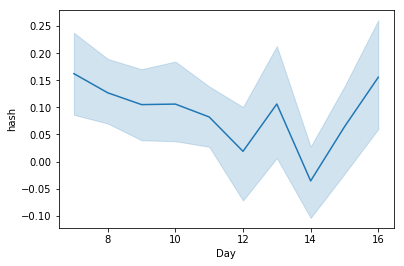

In [74]:

def representative_samples(column, condition):
    return [category for category in column.unique() if column.value_counts()[category] > condition]

#def representative_samples(column, condition):
#    column_categories = column.unique()
#    category_samples_count = column.value_counts()[category]
#    return [category for category in column_categories if category_samples_count > condition]



df = df_bckup.copy(deep=True)
df = df.loc[:,['day', 'sentiment', 'tag']]

# use pd.concat to join the new columns with your original dataframe
#df = pd.concat([df,pd.get_dummies(df['tag'], prefix='tag')],axis=1)
#df.drop(['tag'],axis=1, inplace=True)

subsets = []
for tag in df.tag.unique():
    dfsub = df[df.tag == tag]
    for day in df.day.unique():
        dffin = dfsub[dfsub.day == day]
        if dffin.shape[0] > 20:
            subsets.append(dffin)
            #print()


at, phrase, hasht = [],[],[]
for df in subsets:
    print(df['tag'].unique(), df['day'].unique(), df.shape)
    if df['tag'].unique()[0] == 'at':     at.append(df) 
    if df['tag'].unique()[0] == 'phrase': phrase.append(df) 
    if df['tag'].unique()[0] == 'hash': hasht.append(df)

hasht = pd.concat(hasht)
at = pd.concat(at)
phrase = pd.concat(phrase)


def showplot(df):
    result_plot = pd.DataFrame(df)
    plot = sns.lineplot(x='day',y='sentiment', data=result_plot)
    plot.set(xlabel = 'Day', ylabel =  df['tag'].unique()[0] )
    display(plot)
    
showplot(hasht)

C:\Users\p\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


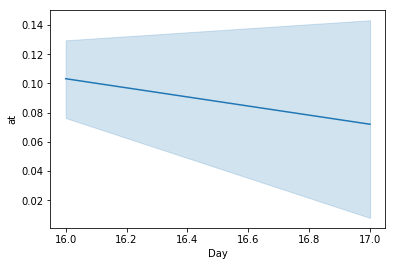

In [75]:
showplot(at)

In [97]:
# Simple improvement ideas (just a mini sketch, each of solutions need to be developed further and tested, i suppose pivoted)

import spacy

nlp = spacy.load('en_core_web_sm')
text = df.text[73]
doc = nlp(text)

print('{:20}{:10}{:10}{:10}{:10}{:10}{:10}'.format('Text', 'Depend', 'PoS', 'Tag', 'MASTER', 'PROCESS', 'DEFINITION'))
print()
for token in doc:
    MASTER = 0
    PROCESS = 0
    DEF = 0
    if token.dep_ in ['nsubj']:
        MASTER +=1
    elif token.dep_ in ['ROOT']:
        PROCESS +=1  
    elif token.dep_ in ['compound']:
        DEF +=1
    elif token.dep_ in ['conj']:
        MASTER -=1
        
    if token.pos_ in ['NOUN']:
        MASTER +=1
    elif token.pos_ in ['VERB']:
        PROCESS += 1
        MASTER -= 1
    elif token.pos_ in ['ADJ']:
        DEF +=1
    
    if MASTER > 0 or PROCESS > 0 or DEF > 0:
        print('{:20}{:10}{:10}{:10}{:10}{:10}{:10}'.format(token.text, token.dep_, token.pos_, token.tag_, MASTER, PROCESS, DEF))
    else:
        print('{:20}{:10}{:10}{:10}'.format(token.text, token.dep_, token.pos_, token.tag_))

Text                Depend    PoS       Tag       MASTER    PROCESS   DEFINITION

so                  advmod    ADP       IN        
of                  prep      ADP       IN        
murderers           pobj      NOUN      NNS                1         0         0
are                 ccomp     VERB      VBP               -1         1         0
women               attr      NOUN      NNS                1         0         0
is                  auxpass   VERB      VBZ               -1         1         0
not                 neg       ADV       RB        
essentially         advmod    ADV       RB        
all                 dep       DET       DT        
stop                ROOT      VERB      VB                -1         2         0
pretending          xcomp     VERB      VBG               -1         1         0
women               nsubj     NOUN      NNS                2         0         0
are                 ccomp     VERB      VBP               -1         1         0
little         